In [1]:
# Requirements
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing Data and Preprocessing

## Dictionaries

Create three dictioanry for the folowing purposes:

- `word2idx` -> Word to index dictionary
- `idx2word` -> Index to word dictionary
- `word2count` -> Count of each unique word to handle rare words

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.word2count[word] = 1
            self.idx2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Handling Unicode and Punctuations

In [3]:
# Unicode to ASCII
# Code from https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

## Trim the dataset

Trim sentences to only get simple sentences (10 words each)

In [4]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

## Prepare the Data

Steps:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [5]:
# Read the data file

def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis ton chef .', 'i m your boss .']


# Sequence to Sequence Model

## Encoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)

## Decoder

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Mechanism Decoder

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # Attention weights
        # Concatenate between embedded input and the previous hidden state
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # bmm means batch matrix matrix product
        # https://pytorch.org/docs/master/torch.html?highlight=bmm#torch.bmm
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        # Combine attention weights
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        # From here on is normal decoder stuff
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training

## Preparing Training Data

Create tensor of input and target words (indexes from the `word2idx` dict). Including the EOS token.


In [9]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training the Model

Note that we've incorporated **Teacher Forcing** in the training.

A great explanation -> https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

In [10]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Helper function to keep track of time and progress.

In [11]:
import time
import math


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

Training process:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [12]:
def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            

    show_plot(plot_losses)

## Plotting results

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation


In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can add a function to evaluate the generated sentences.

In [15]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training and Evaluating

8m 10s (- 114m 31s) (5000 6%) 2.8626
16m 7s (- 104m 45s) (10000 13%) 2.2976
24m 3s (- 96m 14s) (15000 20%) 1.9536
31m 59s (- 87m 59s) (20000 26%) 1.7102
39m 57s (- 79m 55s) (25000 33%) 1.5043
47m 58s (- 71m 58s) (30000 40%) 1.3653
56m 0s (- 64m 1s) (35000 46%) 1.2040
64m 2s (- 56m 2s) (40000 53%) 1.0811
72m 4s (- 48m 2s) (45000 60%) 0.9929
80m 6s (- 40m 3s) (50000 66%) 0.9156
88m 12s (- 32m 4s) (55000 73%) 0.8201
96m 16s (- 24m 4s) (60000 80%) 0.7278
104m 18s (- 16m 2s) (65000 86%) 0.6620
112m 21s (- 8m 1s) (70000 93%) 0.5975
120m 22s (- 0m 0s) (75000 100%) 0.5626


<Figure size 432x288 with 0 Axes>

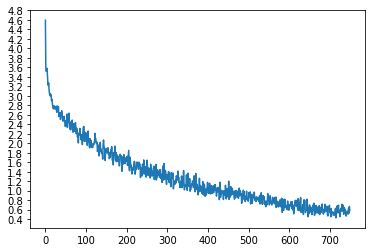

In [16]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

In [17]:
evaluate_randomly(encoder1, attn_decoder1)

> je suis un homme heureux .
= i m a happy man .
< i m a happy man . <EOS>

> vous etes veinard .
= you re in luck .
< you re in luck . <EOS>

> je vais chez ma grand mere .
= i m going to my grandmother s .
< i m going to my my my life . <EOS>

> nous n y allons pas si ?
= we re not going are we ?
< we re not going are we are ? <EOS>

> nous allons tous a la maison .
= we re all going home .
< we re all going home . <EOS>

> je fais partie du club de tennis .
= i m in the tennis club .
< i m in the tennis club . <EOS>

> il est plus vieux mais pas plus sage .
= he s older but no wiser .
< he is older and no longer . . <EOS>

> vous etes tres courageuses .
= you are very brave .
< you are very brave . <EOS>

> je suis bien ton ami non ?
= i am your friend right ?
< i am your friend right ? <EOS>

> elles sont trop grosses .
= they re too fat .
< they re too fat . <EOS>



# Visualizing Attention